### INFO284 Machine Learning eksamen, vår 2024
av ppa007 og ....
levert 30.4.2024

#### Import og versjonskontroll for relevante biblioteker.

In [186]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
pandas version: 2.2.1
matplotlib version: 3.8.3
NumPy version: 1.26.4
SciPy version: 1.12.0
IPython version: 8.21.0
scikit-learn version: 1.4.1.post1
seaborn version: 0.13.2


#### Import av datasettet
Filen er kodet i UTF-8, så den vil bare fungere hvis du har riktig versjon av pandas.

In [187]:
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")

In [188]:
from IPython.display import display

def status_dataframe(dataframe):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    print(f"Datasettet har nå {dataframe.shape[1]} kolonner og {dataframe.shape[0]} rader")
    display(dataframe.head(5))
    dataframe.info()

status_dataframe(df)

Datasettet har nå 45 kolonner og 305434 rader


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                305434 non-null  int64  
 1   Meldingstidspunkt         305434 non-null  object 
 2   Meldingsdato              305434 non-null  object 
 3   Meldingsklokkeslett       305434 non-null  object 
 4   Starttidspunkt            305434 non-null  object 
 5   Startdato                 305434 non-null  object 
 6   Startklokkeslett          305434 non-null  object 
 7   Startposisjon bredde      305434 non-null  object 
 8   Startposisjon lengde      305434 non-null  object 
 9   Hovedområde start (kode)  303433 non-null  float64
 10  Hovedområde start         301310 non-null  object 
 11  Lokasjon start (kode)     303433 non-null  float64
 12  Havdybde start            305434 non-null  int64  
 13  Stopptidspunkt            305434 non-null  o

#### Valg av mål og forbehandling
Våre valgte målvariabler er fangstene av hyse, torsk og sei som kontinuerlige verdier. Dette betyr at det er en kombinasjon av kolonnene ".....", som indikerer fangede arter, og "Rundvekt", som indikerer vekten av fangsten.

Først vil vi sette opp et frø som vi vil bruke i testing for å gjøre resultatene mer sammenlignbare på tvers av ulike modeller.

In [189]:
seed = 32

Neste steg er å ekskludere irrelevante kolonner.
- Fangstår: Datasettet er fra 2018, men inneholder noen rapporter fra 2017 da de ble rapportert inn etter nyttårsaften. Vi fjerner den fordi den bare inneholder 2 unike verdier, hvor over 99% av dem er bare en av dem.

In [190]:
value_counts = df['Fangstår'].value_counts()
print(value_counts)
df.drop(columns = ['Fangstår'], inplace= True)

Fangstår
2018    305416
2017        18
Name: count, dtype: int64


- Nesten alle "navn" og "navn (kode)" er samme informasjonen. Derfor fjerner vi følgende: Hovedområde start (kode), Redskap FAO (kode), Redskap FDIR (kode), Hovedart FAO (kode), Art FAO (kode), Art - FDIR (kode), Art - gruppe (kode), Lengdegruppe (kode).

In [191]:
def test_likhet(dataframe, feature1, feature2):
    value_counts = dataframe.groupby([feature1, feature2]).size().unstack(fill_value=0)

    dict_sum = {}

    for column in value_counts.columns:
        dict_sum.setdefault(column, [])
        dict_sum[column].extend(list(zip(
            value_counts.index[value_counts[column] != 0].tolist(),
            value_counts[value_counts[column] != 0][column].tolist()
        )))
    mismatch = []
    tuple_counts = {key: len(value) for key, value in dict_sum.items()}
    for key, value in tuple_counts.items():
        if value > 1:
            mismatch.append(key)

    if len(mismatch) > 0:
        print(f"Disse kolonnene har verdier som ikke overlapper 100%: {mismatch}")
    else:
        print(f"Verdiene i kolonnene {feature2.name} og {feature1.name} overlapper 100%.")
        print(f"Utskrift av dictionary der nøkkelen er verdier i {feature2.name} og verdien er en tuple av verdien i {feature1.name} og antall forekomster av den:")
        print(dict_sum)
   

In [192]:
test_likhet(df, df["Hovedområde start (kode)"], df["Hovedområde start"])

Verdiene i kolonnene Hovedområde start og Hovedområde start (kode) overlapper 100%.
Utskrift av dictionary der nøkkelen er verdier i Hovedområde start og verdien er en tuple av verdien i Hovedområde start (kode) og antall forekomster av den:
{'Admiralityfeltet': [(16.0, 1909)], 'Bjørnøya': [(20.0, 25265)], 'Britvinfeltet': [(14.0, 47)], 'Danmarkstredet': [(61.0, 639)], 'Eigersundbanken': [(8.0, 45349)], 'Flemish Cap': [(81.0, 47)], 'Fyllas Bank': [(68.0, 243)], 'Færøybanken': [(58.0, 95)], 'Gammelock': [(62.0, 1)], 'Grønlandshavet': [(26.0, 2)], 'Gåsebanken': [(11.0, 1699)], 'Helgelandsbanken': [(6.0, 8591)], 'Hopen': [(23.0, 3161)], 'Kaninbanken': [(1.0, 682)], 'Murmanskkysten': [(2.0, 203)], 'Nord av Horn  (Island)': [(54.0, 62)], 'Nord av Island': [(55.0, 2)], 'Nordkappbanken': [(12.0, 18635)], 'Nordv.- Spitsbergen': [(25.0, 181)], 'Nordvestlige Norskehav': [(38.0, 4)], 'Nordøst av Island': [(56.0, 520)], 'Nordøstområdet': [(17.0, 688)], 'Rockall': [(47.0, 588)], 'Røstbanken til Mal

In [193]:
test_likhet(df, df["Redskap FAO"], df["Redskap FAO (kode)"])

Verdiene i kolonnene Redskap FAO (kode) og Redskap FAO overlapper 100%.
Utskrift av dictionary der nøkkelen er verdier i Redskap FAO (kode) og verdien er en tuple av verdien i Redskap FAO og antall forekomster av den:
{'LL': [('Andre liner', 25028)], 'TX': [('Annen trål (udefinert)', 250)], 'SPR': [('Boat /vessel seines -Pair seines', 939)], 'TB': [('Bunntrål (uspes)', 12786)], 'OTB': [('Bunntrål, otter', 120487)], 'PTB': [('Bunntrål, par', 3335)], 'TBS': [('Bunntrål, reke', 21647)], 'LTL': [('Dorg/harp/snik', 16)], 'GNC': [('Encircling gillnets*', 349)], 'OTM': [('Flytetrål, otter', 2732)], 'PTM': [('Flytetrål, par', 1512)], 'TMS': [('Flytetrål, reke', 774)], 'TM': [('Flytetrål, uspesifisert', 2285)], 'GEN': [('Gillnets and entangling nets (unspec)*', 13910)], 'HAR': [('Harpun,div.', 494)], 'LHP': [('Juksa/pilk, manuell', 19)], 'OTT': [('Otter dobbeltrål', 2836)], 'PT': [('Partrål, uspesifisert', 309)], 'GNS': [('Settegarn', 649)], 'LLS': [('Setteline', 18964)], 'DRB': [('Skrape, meka

In [194]:
test_likhet(df, df["Redskap FDIR (kode)"], df["Redskap FDIR"])

Verdiene i kolonnene Redskap FDIR og Redskap FDIR (kode) overlapper 100%.
Utskrift av dictionary der nøkkelen er verdier i Redskap FDIR og verdien er en tuple av verdien i Redskap FDIR (kode) og antall forekomster av den:
{'Andre liner': [(32.0, 43992)], 'Annet': [(80.0, 462)], 'Bunntrål': [(51.0, 120487)], 'Bunntrål par': [(52.0, 3335)], 'Dobbeltrål': [(58.0, 2836)], 'Dorg/harp/snik': [(34.0, 16)], 'Flytetrål': [(53.0, 2732)], 'Flytetrål par': [(54.0, 1512)], 'Harpun og lignende uspesifiserte typer': [(70.0, 494)], 'Juksa/pilk': [(33.0, 19)], 'Reketrål': [(55.0, 22421)], 'Settegarn': [(22.0, 649)], 'Snurpenot/ringnot': [(11.0, 12711)], 'Snurrevad': [(61.0, 51615)], 'Teiner': [(42.0, 6818)], 'Udefinert garn': [(20.0, 19277)], 'Udefinert trål': [(50.0, 15870)]}


In [195]:
test_likhet(df, df["Hovedart FAO"], df["Hovedart FAO (kode)"])

Verdiene i kolonnene Hovedart FAO (kode) og Hovedart FAO overlapper 100%.
Utskrift av dictionary der nøkkelen er verdier i Hovedart FAO (kode) og verdien er en tuple av verdien i Hovedart FAO og antall forekomster av den:
{'ARG': [('Strømsild/Vassild', 298)], 'ARU': [('Vassild', 1120)], 'ARY': [('Strømsild', 314)], 'BFT': [('Makrellstørje', 2)], 'BHG': [('Nordlig lysprikkfisk', 3)], 'BLI': [('Blålange', 37)], 'BLW': [('Blåhval', 1)], 'CAA': [('Gråsteinbit', 203)], 'CAB': [('Blåsteinbit', 163)], 'CAP': [('Lodde', 1378)], 'CAS': [('Flekksteinbit', 896)], 'CAT': [('Steinbiter', 112)], 'CMO': [('Havmus', 18)], 'COD': [('Torsk', 86215)], 'CRE': [('Taskekrabbe', 532)], 'CRQ': [('Snøkrabbe', 6070)], 'CUS': [('Pink cusk-eel*', 196)], 'DAB': [('Sandflyndre', 3)], 'DGS': [('Pigghå', 138)], 'FLE': [('Skrubbe', 8)], 'GAD': [('Annen torskefisk', 12)], 'GDG': [('Sølvtorsk', 70)], 'GFB': [('Skjellbrosme', 27)], 'GHL': [('Blåkveite', 4986)], 'HAD': [('Hyse', 28176)], 'HAL': [('Kveite', 95)], 'HER': [(

In [196]:
test_likhet(df, df["Art FAO"], df["Art FAO (kode)"])

Verdiene i kolonnene Art FAO (kode) og Art FAO overlapper 100%.
Utskrift av dictionary der nøkkelen er verdier i Art FAO (kode) og verdien er en tuple av verdien i Art FAO og antall forekomster av den:
{'SQE': [('Akkar', 252)], 'FLX': [('Annen flatfisk', 4)], 'PLZ': [('Annen flyndre', 416)], 'SLX': [('Annen laksefisk', 1)], 'MAX': [('Annen makrell', 1)], 'MZZ': [('Annen marin fisk', 2378)], 'SIX': [('Annen sardin', 4)], 'SRX': [('Annen skate og rokke', 2136)], 'GAD': [('Annen torskefisk', 2)], 'ANE': [('Ansjos', 1)], 'KRI': [('Antarktisk krill', 552)], 'TOA': [('Antarktisk tannfisk', 34)], 'CEP': [('Blekkspruter uspes.', 4)], 'BLW': [('Blåhval', 1)], 'BRF': [('Blåkjeft', 89)], 'GHL': [('Blåkveite', 8046)], 'BLI': [('Blålange', 991)], 'CAB': [('Blåsteinbit', 2129)], 'FUV': [('Blæretang', 1)], 'MON': [('Breiflabb', 8543)], 'SPR': [('Brisling', 268)], 'USK': [('Brosme', 9167)], 'SKJ': [('Bukstripet pelamide', 1)], 'RJA': [('Burton-skate', 2)], 'SQC': [('Common squids nei *', 35)], 'EPI': 

In [197]:
test_likhet(df, df["Art - FDIR (kode)"], df["Art - FDIR"])

Verdiene i kolonnene Art - FDIR og Art - FDIR (kode) overlapper 100%.
Utskrift av dictionary der nøkkelen er verdier i Art - FDIR og verdien er en tuple av verdien i Art - FDIR (kode) og antall forekomster av den:
{'Akkar': [(2634.0, 252)], 'Annen blekksprut': [(2639.0, 8)], 'Annen flatfisk': [(2399.0, 4)], 'Annen flyndre': [(2329.0, 416)], 'Annen laksefisk': [(799.0, 1)], 'Annen makrell': [(2015.0, 1)], 'Annen marin fisk': [(2919.0, 2378)], 'Annen sardin': [(612.0, 4)], 'Annen skate og rokke': [(599.0, 2136)], 'Annen vanlig ti-armet blekksprut': [(2636.0, 2)], 'Ansjos': [(621.0, 1)], 'Antarktisk krill': [(2513.0, 552)], 'Antarktisk tannfisk': [(6152.0, 34)], 'Blekksprut, uspes.': [(2638.0, 4)], 'Blåhval': [(2733.0, 1)], 'Blåkjeft': [(2205.0, 89)], 'Blåkveite': [(2313.0, 8046)], 'Blålange': [(1024.0, 991)], 'Blåsteinbit': [(1713.0, 2129)], 'Blæretang': [(2817.0, 1)], 'Breiflabb': [(2411.0, 8543)], 'Brisling': [(615.0, 268)], 'Brosme': [(1021.0, 9167)], 'Bukstripet pelamide': [(2018.0, 

In [198]:
test_likhet(df, df["Art - gruppe (kode)"], df["Art - gruppe"])

Verdiene i kolonnene Art - gruppe og Art - gruppe (kode) overlapper 100%.
Utskrift av dictionary der nøkkelen er verdier i Art - gruppe og verdien er en tuple av verdien i Art - gruppe (kode) og antall forekomster av den:
{'Andre skalldyr, bløtdyr og pigghuder': [(520.0, 1329)], 'Annen flatfisk, bunnfisk og dypvannsfisk': [(320.0, 25267)], 'Annen pelagisk fisk': [(120.0, 1802)], 'Annen torskefisk': [(220.0, 45286)], 'Antarktisk krill': [(506.0, 552)], 'Blåkveite': [(301.0, 8046)], 'Brunalger': [(901.0, 685)], 'Dypvannsreke': [(505.0, 13678)], 'Haifisk': [(401.0, 481)], 'Hyse': [(202.0, 39120)], 'Kolmule': [(105.0, 2843)], 'Kongekrabbe, annen': [(504.0, 23)], 'Kystbrisling': [(110.0, 268)], 'Lodde': [(101.0, 1188)], 'Makrell': [(104.0, 3013)], 'Mesopelagisk fisk': [(111.0, 63)], 'Raudåte': [(507.0, 206)], 'Sei': [(203.0, 42557)], 'Sild, annen': [(103.0, 6006)], 'Sjøpattedyr': [(9903.0, 300)], 'Skater og annen bruskfisk': [(402.0, 4067)], 'Snøkrabbe': [(501.0, 6070)], 'Steinbiter': [(304

In [199]:
test_likhet(df, df["Lengdegruppe (kode)"], df["Lengdegruppe"])

Verdiene i kolonnene Lengdegruppe og Lengdegruppe (kode) overlapper 100%.
Utskrift av dictionary der nøkkelen er verdier i Lengdegruppe og verdien er en tuple av verdien i Lengdegruppe (kode) og antall forekomster av den:
{'15-20,99 m': [(3.0, 35893)], '21-27,99 m': [(4.0, 57723)], '28 m og over': [(5.0, 211134)]}


In [200]:
df.drop(columns=["Hovedområde start (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Art FAO (kode)", "Art - FDIR (kode)", "Art - gruppe (kode)", "Lengdegruppe (kode)"], inplace=True)
status_dataframe(df)

Datasettet har nå 36 kolonner og 305434 rader


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO,Redskap FDIR,Hovedart FAO,Hovedart - FDIR (kode),Art FAO,Art - FDIR,Art - gruppe,Rundvekt,Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,"Flytetrål, otter",Flytetrål,Antarktisk krill,2513.0,Antarktisk krill,Antarktisk krill,Antarktisk krill,706714.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Hyse,Hyse,Hyse,9594.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Torsk,Torsk,Torsk,8510.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Blåkveite,Blåkveite,Blåkveite,196.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Sei,Sei,Sei,134.0,28 m og over,1476.0,NaN,"12,6","56,8"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                305434 non-null  int64  
 1   Meldingstidspunkt         305434 non-null  object 
 2   Meldingsdato              305434 non-null  object 
 3   Meldingsklokkeslett       305434 non-null  object 
 4   Starttidspunkt            305434 non-null  object 
 5   Startdato                 305434 non-null  object 
 6   Startklokkeslett          305434 non-null  object 
 7   Startposisjon bredde      305434 non-null  object 
 8   Startposisjon lengde      305434 non-null  object 
 9   Hovedområde start         301310 non-null  object 
 10  Lokasjon start (kode)     303433 non-null  float64
 11  Havdybde start            305434 non-null  int64  
 12  Stopptidspunkt            305434 non-null  object 
 13  Stoppdato                 305434 non-null  o

In [201]:
test_likhet(df, df["Hovedområde stopp (kode)"], df["Hovedområde stopp"])

Disse kolonnene har verdier som ikke overlapper 100%: ['Admiralityfeltet', 'Bjørnøya', 'Britvinfeltet', 'Eigersundbanken', 'Færøybanken', 'Gåsebanken', 'Helgelandsbanken', 'Hopen', 'Kaninbanken', 'Murmanskkysten', 'Nordkappbanken', 'Nordøst av Island', 'Nordøstområdet', 'Rockall', 'Røstbanken til Malangsgrunnen', 'Sentralbanken', 'Sentrale Nordsjø', 'Sentrale Norskehav', 'Shetland', 'Skagerrak', 'Skolpenbanken', 'Storbanken', 'Storegga-Frøyabanken', 'Storfjord/Hinlopenstredet', 'Sørlige Norskehav', 'Sørvest av Spitsbergen', 'Thor Iversens Bank', 'Vest av Færøyene', 'Vest av Irland', 'Vest av Skottland (Hebridene)', 'Vest av Tromsøflaket', 'Vest-Finnmark', 'Vest-Spitsbergen', 'Vestfjorden (Lofoten)', 'Vestlige Norskehav', 'Vikingbanken', 'Øst av Færøyene', 'Øst av Island', 'Øst-Finnmark', 'Østlige Norskehav']


- Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde: Disse kolonnene representerer liggnende informasjon om fangstbåten på forskjellige måter. Utifra det vi ønsker å predikere virker det mest hennsikstmessig å kun beholde bruttotonasje. Men for å gjøre det må vi først bevise likheten mellom de forskjellige variablene.

1. Bruttotonnasje 1969 og Bruttotonnasje annen: Når den ene kolonnen er tom har den andre data. Vi slår sammen begge kolonene og fjerner de radene hvor begge kolonnen er tomme.
2. Fartøylengde er en mer nyansert versjon av Lengdegruppe.
3. Fartøylengde og Bredde har en sterk korelasjon.
4. Fartøylengde og Bruttotonnasje har en sterk korelasjon.

In [202]:
b_nan = df['Bruttotonnasje 1969'].notnull() & df['Bruttotonnasje annen'].isnull()
a_nan = df['Bruttotonnasje annen'].notnull() & df['Bruttotonnasje 1969'].isnull()
both_nan = df['Bruttotonnasje 1969'].isnull() & df['Bruttotonnasje annen'].isnull()

print(f"""Kun Bruttotonnasje 1969 rader har verdi: {b_nan.sum()}
Kun Bruttotonnasje annen rader har verdi: {a_nan.sum()}
Begge kolonner har nan verdi: {both_nan.sum()}""")

df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969"], inplace=True)
df = df.dropna(subset=['Bruttotonnasje'])

Kun Bruttotonnasje 1969 rader har verdi: 227689
Kun Bruttotonnasje annen rader har verdi: 68458
Begge kolonner har nan verdi: 2971


In [203]:
df['Fartøylengde'] = df['Fartøylengde'].str.replace(',', '.').astype(float)
df['Bredde'] = df['Bredde'].str.replace(',', '.').astype(float)

In [204]:
min_max_values = df.groupby('Lengdegruppe')['Fartøylengde'].agg(['min', 'max'])
print(min_max_values)

                min     max
Lengdegruppe               
15-20,99 m    15.01   20.99
21-27,99 m    21.07   27.99
28 m og over  28.10  133.88


Correlation coefficient: 0.9444557211700517


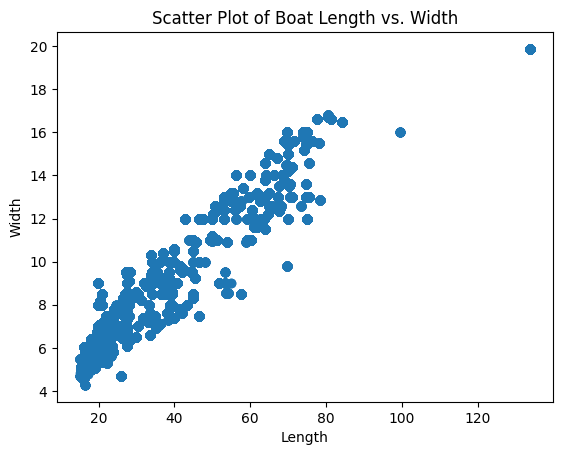

In [205]:
correlation = df['Fartøylengde'].corr(df['Bredde'])
print("Correlation coefficient:", correlation)

# Scatter plot of length vs. width
plt.scatter(df['Fartøylengde'], df['Bredde'])
plt.xlabel('Length')
plt.ylabel('Width')
plt.title('Scatter Plot of Boat Length vs. Width')
plt.show()

Correlation coefficient: 0.9237180814592622


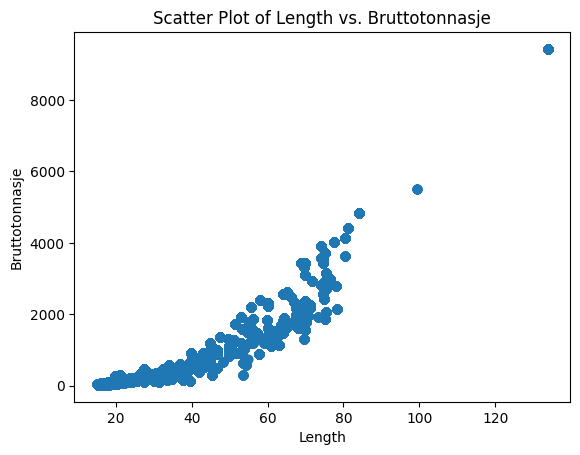

In [206]:
correlation = df['Fartøylengde'].corr(df['Bruttotonnasje'])
print("Correlation coefficient:", correlation)

# Scatter plot of length vs. width
plt.scatter(df['Fartøylengde'], df['Bruttotonnasje'])
plt.xlabel('Length')
plt.ylabel('Bruttotonnasje')
plt.title('Scatter Plot of Length vs. Bruttotonnasje')
plt.show()

In [207]:
df.drop(columns=["Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)
status_dataframe(df)

Datasettet har nå 32 kolonner og 302463 rader


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO,Redskap FDIR,Hovedart FAO,Hovedart - FDIR (kode),Art FAO,Art - FDIR,Art - gruppe,Rundvekt,Bruttotonnasje
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,"Flytetrål, otter",Flytetrål,Antarktisk krill,2513.0,Antarktisk krill,Antarktisk krill,Antarktisk krill,706714.0,9432.0
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Hyse,Hyse,Hyse,9594.0,1476.0
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Torsk,Torsk,Torsk,8510.0,1476.0
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Blåkveite,Blåkveite,Blåkveite,196.0,1476.0
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Sei,Sei,Sei,134.0,1476.0


<class 'pandas.core.frame.DataFrame'>
Index: 302463 entries, 0 to 305433
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                302463 non-null  int64  
 1   Meldingstidspunkt         302463 non-null  object 
 2   Meldingsdato              302463 non-null  object 
 3   Meldingsklokkeslett       302463 non-null  object 
 4   Starttidspunkt            302463 non-null  object 
 5   Startdato                 302463 non-null  object 
 6   Startklokkeslett          302463 non-null  object 
 7   Startposisjon bredde      302463 non-null  object 
 8   Startposisjon lengde      302463 non-null  object 
 9   Hovedområde start         298378 non-null  object 
 10  Lokasjon start (kode)     300501 non-null  float64
 11  Havdybde start            302463 non-null  int64  
 12  Stopptidspunkt            302463 non-null  object 
 13  Stoppdato                 302463 non-null  object

- Meldingstidspunkt, Meldingsdato, Meldingsklokkeslett: fjernes ettersom dette er informasjon etter 